In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# ======================
# PARAMETERS TO TAKE NOTE FOR THE PROJECT
# ======================
IMG_SIZE = 380          # Same as BDP, change the size of img to 380 x 380
BATCH_SIZE = 32         # Images processed at once
NUM_EPOCHS_INITIAL = 10
NUM_EPOCHS_FINETUNE = 5
VAL_SPLIT = 0.2
SEED = 42

# When running this in your own drive, change it to match the name of the folder in drive
DATA_PATH = "/content/drive/MyDrive/DataSet"

# Checking to see if the mount follows the datapath
print("DATA_PATH exists?", os.path.exists(DATA_PATH))
print("Top-level folders (classes) preview:", os.listdir(DATA_PATH)[:10])


# STEP 1: DATA PREPARATION & AUGMENTATION (ResNet50)
# ====================================================================
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,   # ResNet-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

val_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    validation_split=VAL_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

validation_generator = val_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,   # keep False for clean evaluation (confusion matrix)
    seed=SEED
)

num_classes = len(train_generator.class_indices)
print("Number of Classes:", num_classes)
print("Class indices:", train_generator.class_indices)

DATA_PATH exists? True
Top-level folders (classes) preview: ['Airbus', 'ATR', 'Boeing']
Found 1756 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Number of Classes: 3
Class indices: {'ATR': 0, 'Airbus': 1, 'Boeing': 2}


In [ ]:
# STEP 2: LOAD THE PRETRAINED MODEL & BUILD A CUSTOM HEAD (ResNet50 baseline)

# Load the ResNet50
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base for initial training so that only specific head is trained
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)   # keep similar head style to teammate
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 386, 386,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 190, 190,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 190, 190,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 190, 190,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 192, 192,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 95, 95,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 95, 95,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 95, 95,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 95, 95,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 95, 95,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 95, 95,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 95, 95,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 95, 95,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 95, 95,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 95, 95,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 95, 95,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# STEP 3: INITIAL TRAINING
# Training the head only for transfer learning

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS_INITIAL,
    callbacks=[lr_scheduler, early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1057s 19s/step - accuracy: 0.5055 - loss: 1.0248 - val_accuracy: 0.6156 - val_loss: 0.7847 - learning_rate: 1.0000e-04
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5861 - loss: 0.8023 - val_accuracy: 0.6407 - val_loss: 0.7551 - learning_rate: 1.0000e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6497 - loss: 0.7152 - val_accuracy: 0.6751 - val_loss: 0.6631 - learning_rate: 1.0000e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6568 - loss: 0.6841 - val_accuracy: 0.6773 - val_loss: 0.6389 - learning_rate: 1.0000e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6886 - loss: 0.6308 - val_accuracy: 0.7277 - val_loss: 0.6036 - learning_rate: 1.0000e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7239 - loss: 0.5743 - val_accuracy: 0.7391 - val_loss: 0.5855 - learning_rate: 1.0000e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7516 - lo

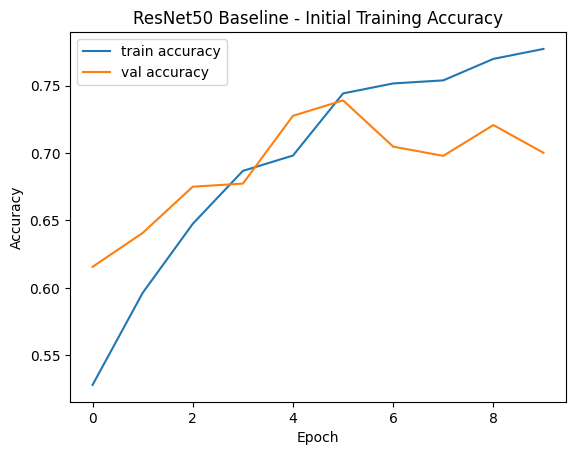

In [ ]:
# Plot training history just to show
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('ResNet50 Baseline - Initial Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# STEP 4: FINE-TUNING (unfreeze last layers)
# ------------------------------------------

# Unfreeze the top layers of the base model to start training
base_model.trainable = True

# Keep most layers frozen; unfreeze last 30 layers (adjust if needed)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# (Optional) keep BatchNorm frozen for stability
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=SGD(learning_rate=1e-5, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS_FINETUNE,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7671 - loss: 0.4793 - val_accuracy: 0.7117 - val_loss: 0.5708 - learning_rate: 1.0000e-05
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8014 - loss: 0.4685 - val_accuracy: 0.7048 - val_loss: 0.5711 - learning_rate: 1.0000e-05
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7895 - loss: 0.4829 - val_accuracy: 0.7117 - val_loss: 0.5666 - learning_rate: 1.0000e-05
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7903 - loss: 0.4711 - val_accuracy: 0.7071 - val_loss: 0.5661 - learning_rate: 1.0000e-05
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7847 - loss: 0.4723 - val_accuracy: 0.7231 - val_loss: 0.5623 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


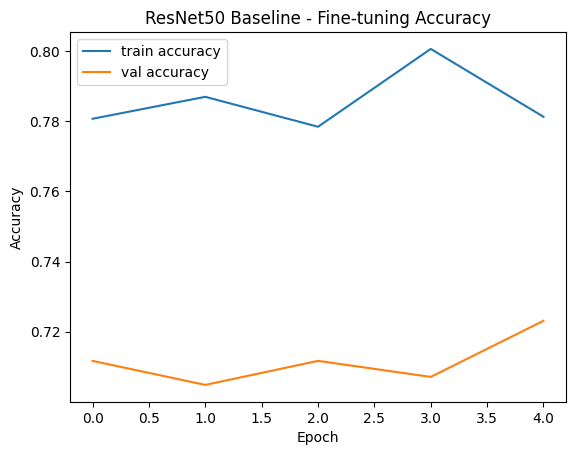

In [ ]:
# Plot fine-tuning history
plt.plot(history_finetune.history['accuracy'], label='train accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy')
plt.title('ResNet50 Baseline - Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

=== ResNet50 Baseline Classification Report ===
              precision    recall  f1-score   support

         ATR     0.8864    0.9750    0.9286        40
      Airbus     0.7629    0.7375    0.7500       240
      Boeing     0.6211    0.6369    0.6289       157

    accuracy                         0.7231       437
   macro avg     0.7568    0.7831    0.7692       437
weighted avg     0.7233    0.7231    0.7228       437

Confusion matrix (rows=true, cols=pred):
[[ 39   0   1]
 [  3 177  60]
 [  2  55 100]]


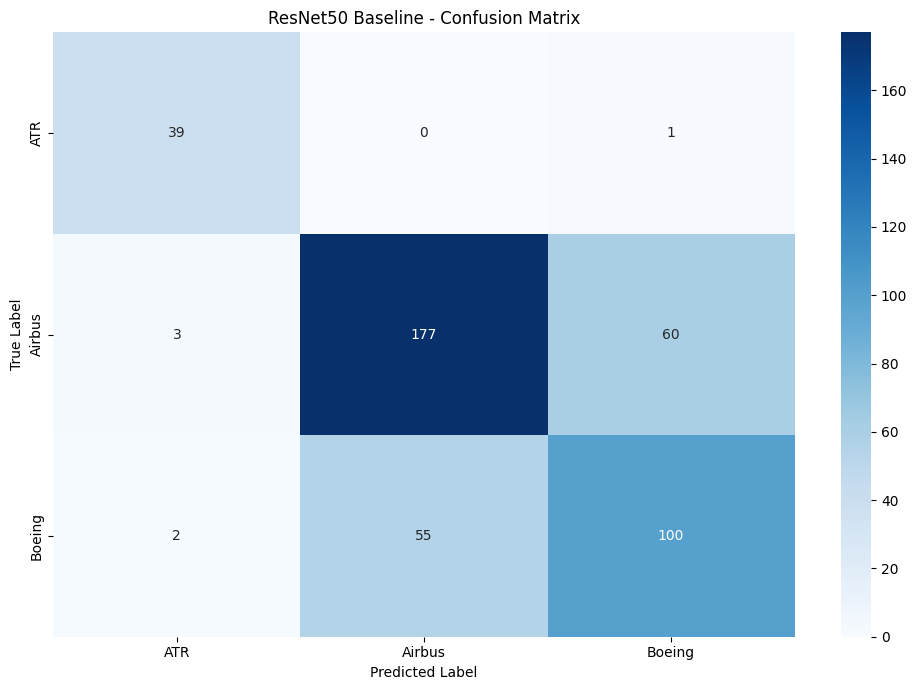

Saved confusion matrix to: /content/drive/MyDrive/CSCI218/resnet50_confusion_matrix.png


In [ ]:
# STEP 5: EVALUATION (same format for comparison)
# ----------------------------------------------

# To reset the generator for prediction to start at first image and rerun the model on the validation images
# STEP 5: EVALUATION (ResNet50 Baseline)



# Reset generator so predictions start from first image
validation_generator.reset()

# Get predictions
probs = model.predict(validation_generator, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print classification report
print("=== ResNet50 Baseline Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Plot confusion matrix (COUNTS)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ResNet50 Baseline - Confusion Matrix")
plt.tight_layout()

# Save image
out_path = "/content/drive/MyDrive/CSCI218/resnet50_confusion_matrix.png"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved confusion matrix to:", out_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


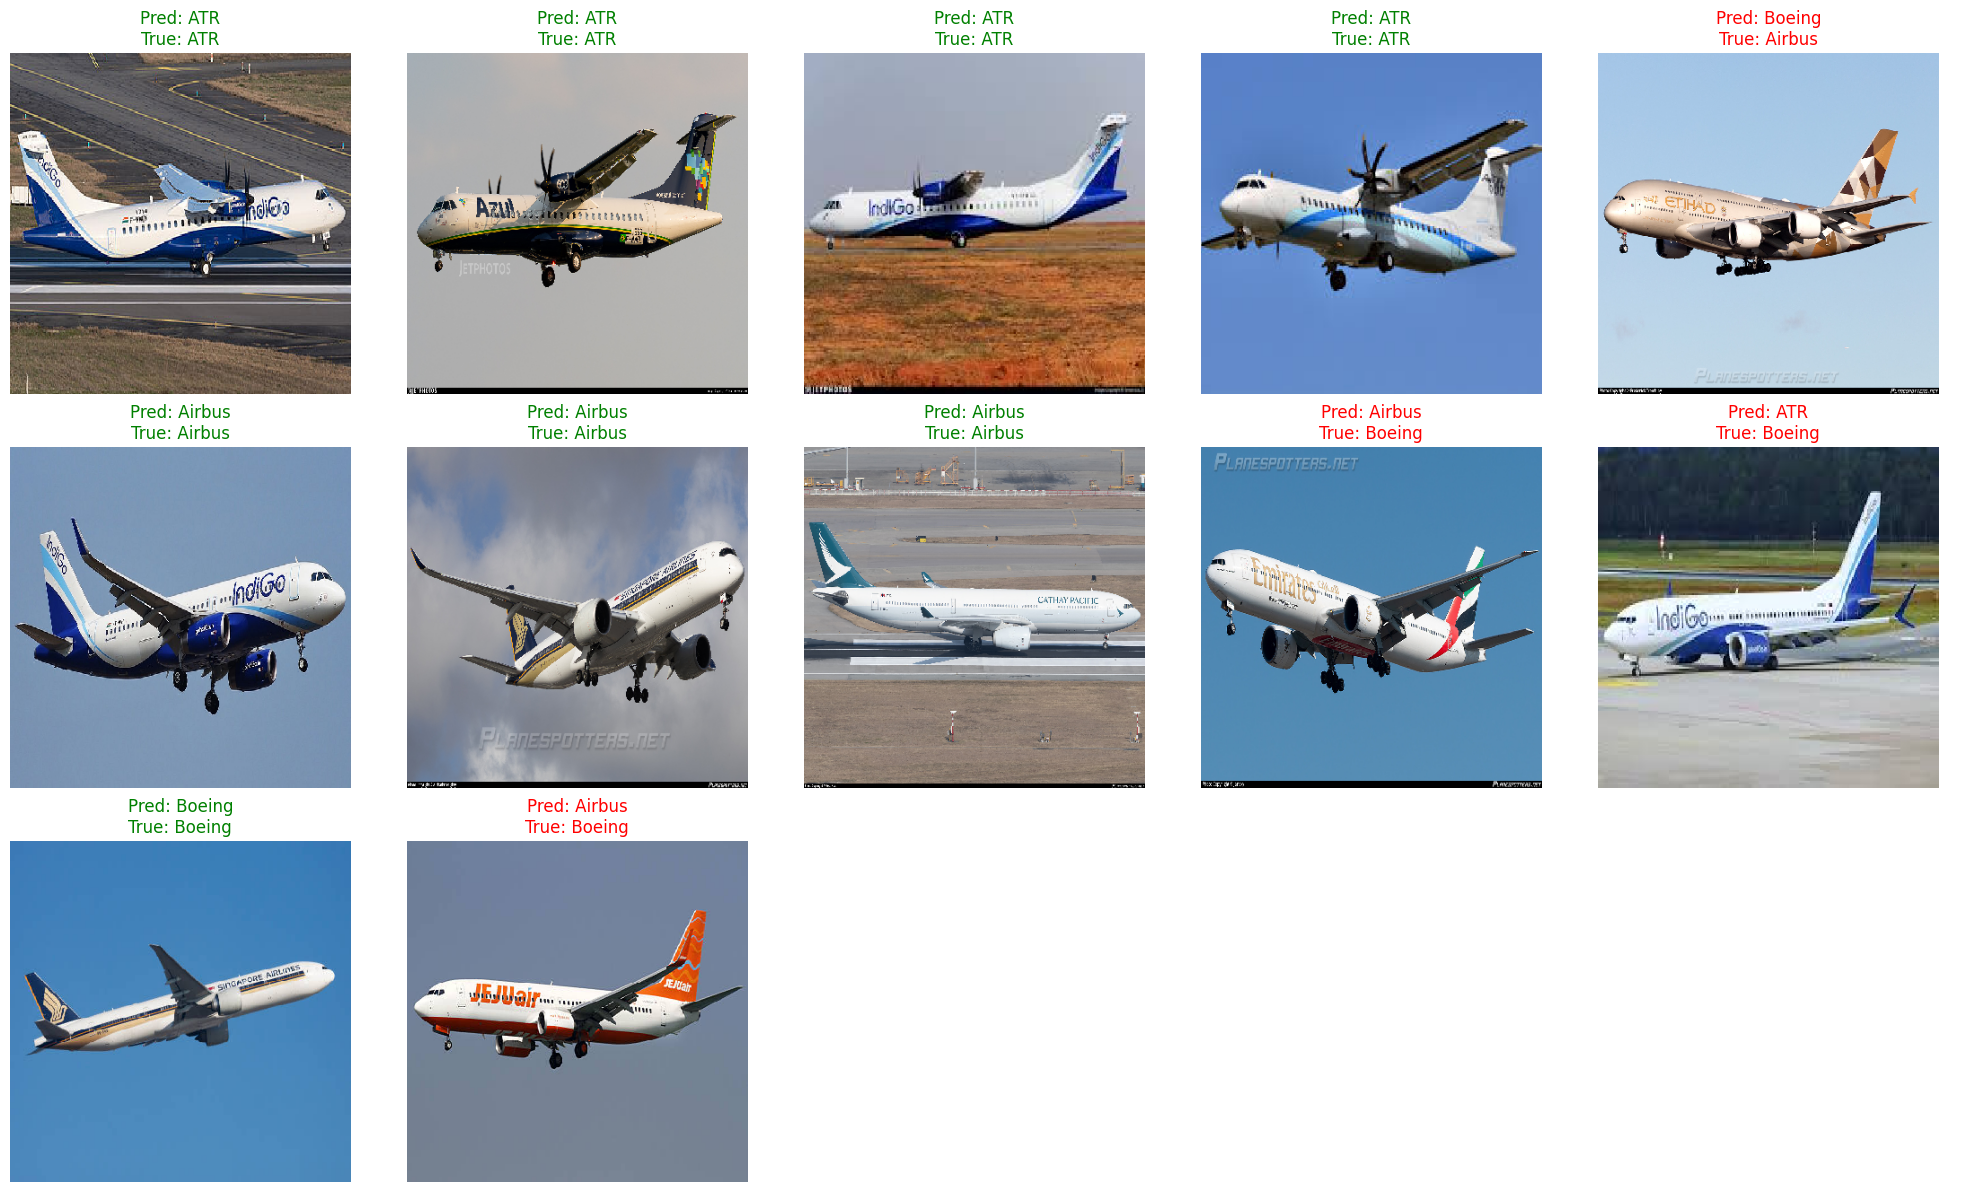

In [ ]:
from tensorflow.keras.preprocessing import image
# The preprocess_input function used here should be consistent with the model's preprocessing.
# Given ResNet50 is used, we'll use resnet_preprocess from the global scope.

def preprocess_image(img_path, target_size=(380, 380)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = resnet_preprocess(img_array)  # Use ResNet-specific preprocessing
    return img_array, img

def predict_from_directory(directory_path):
    class_labels = {0: 'ATR', 1: 'Airbus', 2: 'Boeing'}

    images, preds, trues = [], [], []

    # Loop over folders
    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img_array, img = preprocess_image(img_path)

                prediction = model.predict(img_array)
                pred_idx = np.argmax(prediction, axis=1)[0]
                pred_label = class_labels[pred_idx]

                images.append(img)
                preds.append(pred_label)
                trues.append(class_name)

    # Display images in a grid
    num_images = len(images)
    cols = 5  # Max images per row
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(-1)

    for ax, img, pred, true in zip(axes, images, preds, trues):
        ax.imshow(img)
        ax.axis("off")
        color = "green" if pred == true else "red"
        ax.set_title(f"Pred: {pred}\nTrue: {true}", color=color, fontsize=12)

    # Turn off extra axes if any
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
directory_path = '/content/drive/MyDrive/test_images_2'
predict_from_directory(directory_path)
